In [1]:
import sounddevice as sd
import numpy as np
import librosa, os
import tensorflow as tf
import threading  # Import threading module
import soundfile as sf 
import os
# os.chdir(os.path.dirname(os.path.abspath(__file__)))  # Change working directory to the directory of this file

# Majority voting from windows. 
# decibel cutoffs/Thresholding
#
class AudioAnalyzer:
    def __init__(self, duration=3):
        self.samplerate = 16000
        self.duration = duration
        self.audio_data = []
        self.lock = threading.Lock()  # Create a lock for thread safety
        self.audio_waveform = None
        self.interpreter = []
        with open('../soundClassifier/labels.txt', 'r') as file:
            self.labels = [line.strip() for line in file.readlines()]
        self.prep_NN()

    def prep_NN(self):
        """Prepares the neural network by loading the model and allocating tensors."""
        for key in self.labels:
            model_path=f'../soundClassifier/indv_model/model_{key}.tflite'
            interpreter = tf.lite.Interpreter(model_path=model_path)
            interpreter.allocate_tensors()
            input_details = interpreter.get_input_details()
            output_details = interpreter.get_output_details()
            self.interpreter.append([key, interpreter, input_details, output_details])

    def callback(self, indata, frames, time, status):
        """Callback function to handle audio input data."""
        if status:
            print(status)
        with self.lock:  # Lock access to audio_data
            self.audio_data += list(indata.copy())

    def audio_stream(self):
        """Starts the audio stream and keeps it alive indefinitely."""
        with sd.InputStream(device=1, samplerate=self.samplerate, channels=1, callback=self.callback):
            print("Audio streaming started. Press Ctrl+C to stop.")
            while True:  # Run indefinitely
                sd.sleep(self.duration * 1000)  # Sleep for a short duration to keep the stream alive

    def start_stream(self):
        """Starts the audio stream in a separate thread and processes audio data."""
        try:
            # Start the audio stream in a separate thread
            threading.Thread(target=self.audio_stream, daemon=True).start()
            while True:  # Main thread can perform other tasks
                threading.Thread(target=self.process_audio).start()  # Start get_mfcc in a new thread
                sd.sleep(self.duration * 1000)  # Sleep to control the frequency of MFCC processing
        except KeyboardInterrupt:
            print("Streaming stopped by user.")

    def process_audio(self):        
        """Processes the audio data to calculate decibels and MFCC, and predicts labels."""
        with self.lock:  # Lock access to audio_data
            if self.audio_data:  # Check if there is audio data to process
                self.audio_waveform = np.concatenate(self.audio_data.copy()).flatten()
                self.audio_data = []  # Clear audio_data after processing
        if self.audio_waveform is not None:
            db = self.calculate_decibel(self.audio_waveform)
            chunk_size = int(1 * self.samplerate)  # 0.5 ms chunk size
            audio_chunks = [self.audio_waveform[i:i + chunk_size] for i in range(0, len(self.audio_waveform), chunk_size) if i + chunk_size <= len(self.audio_waveform)]
            mfcc = [self.get_mfcc(chunk) for chunk in audio_chunks if len(chunk) > 0]  # Get MFCC for each chunk
            if mfcc is not None:
                output_data = [self.predict_labels(mf) for mf in mfcc[0]]
                return dict(audio_waveform = self.audio_waveform, samplerate = self.samplerate, prediction=output_data, raw_pred=output_data, fsdb=db) 
                # if not os.path.exists('dataset'):
                #     os.makedirs('dataset')
                # sf.write(f'dataset/{ret}.wav', self.audio_waveform, self.samplerate)

    def calculate_decibel(self, audio_waveform:list)-> float:
        """Calculates the decibel level of the given audio waveform."""
        rms = np.sqrt(np.mean(np.square(audio_waveform)))
        if rms > 0:
            decibels = 20 * np.log10(rms)
        else:
            decibels = -np.inf 
        return decibels
    
    def get_mfcc(self, audio_waveform):
        """Extracts MFCC features from the audio waveform."""
        mfccs = librosa.feature.mfcc(y=audio_waveform, sr=self.samplerate, n_mfcc=40)
        return mfccs.T

    def predict_labels(self, x_test):
        """Predicts labels for the given input using the neural network."""
        x_test_input = np.array([x_test.reshape(1, len(x_test), 1)], dtype=np.float32)
        output_data = []
        for key, interpreter, input_details, output_details in self.interpreter:
            interpreter.set_tensor(input_details[0]['index'], x_test_input[0])
            interpreter.invoke()
            output_data.append(interpreter.get_tensor(output_details[0]['index'])[0]  )
        return output_data

# if __name__ == "__main__":
#     analyzer = AudioAnalyzer()
#     analyzer.start_stream()


In [2]:
# from executer_indi import *
import os
import urllib.parse
import librosa

def load_audio_files(file_path):
    """Loads audio files from the specified directory."""
    audio_data, samplerate = librosa.load(file_path, sr=None)  # Load audio file with original sampling rate
    return audio_data, samplerate




if __name__ == "__main__":
    encoded_str = "../soundClassifier/dataset/d95e05c6-%EA%B8%88%EC%9A%94%EC%9D%BC_%EC%98%A4%ED%9B%84_1-26.m4a"
    decoded_str = urllib.parse.unquote(encoded_str)
    audio_files, sr = load_audio_files(decoded_str) # Load audio files from the dataset directory
    chunk_size = 1 * sr  # Define chunk size as 3 seconds
    hop_size=int(len(audio_files)/100)
    audio_chunks = [audio_files[i:i + chunk_size] for i in range(0, len(audio_files) - chunk_size + 1, hop_size)]  # Split audio_files into chunks with hops
        # Assuming there's a method in the AudioAnalyzer class to handle audio data
    print(len(audio_chunks))
    analyzer = AudioAnalyzer()
    data = []
    for idx, chunck in enumerate(audio_chunks):
        analyzer.audio_waveform = chunck  # Set the audio waveform
        analyzer.samplerate = sr  # Set the samplerate
        ret = analyzer.process_audio()  # Call the process_audio method to handle the audio data
        data.append(ret)

In [45]:

def threshold_filter(values, tres=0.5):
    """Sets values to 0 if they are under the threshold, otherwise keeps the original value."""
    return [value[0] if value[0] >= tres else 0 for value in values]

In [46]:
data[0].keys()

dict_keys(['audio_waveform', 'samplerate', 'prediction', 'raw_pred', 'fsdb'])

In [66]:
arr = np.array([np.mean([d for d in d['raw_pred']], axis=0).flatten() for d in data]).T

input overflow


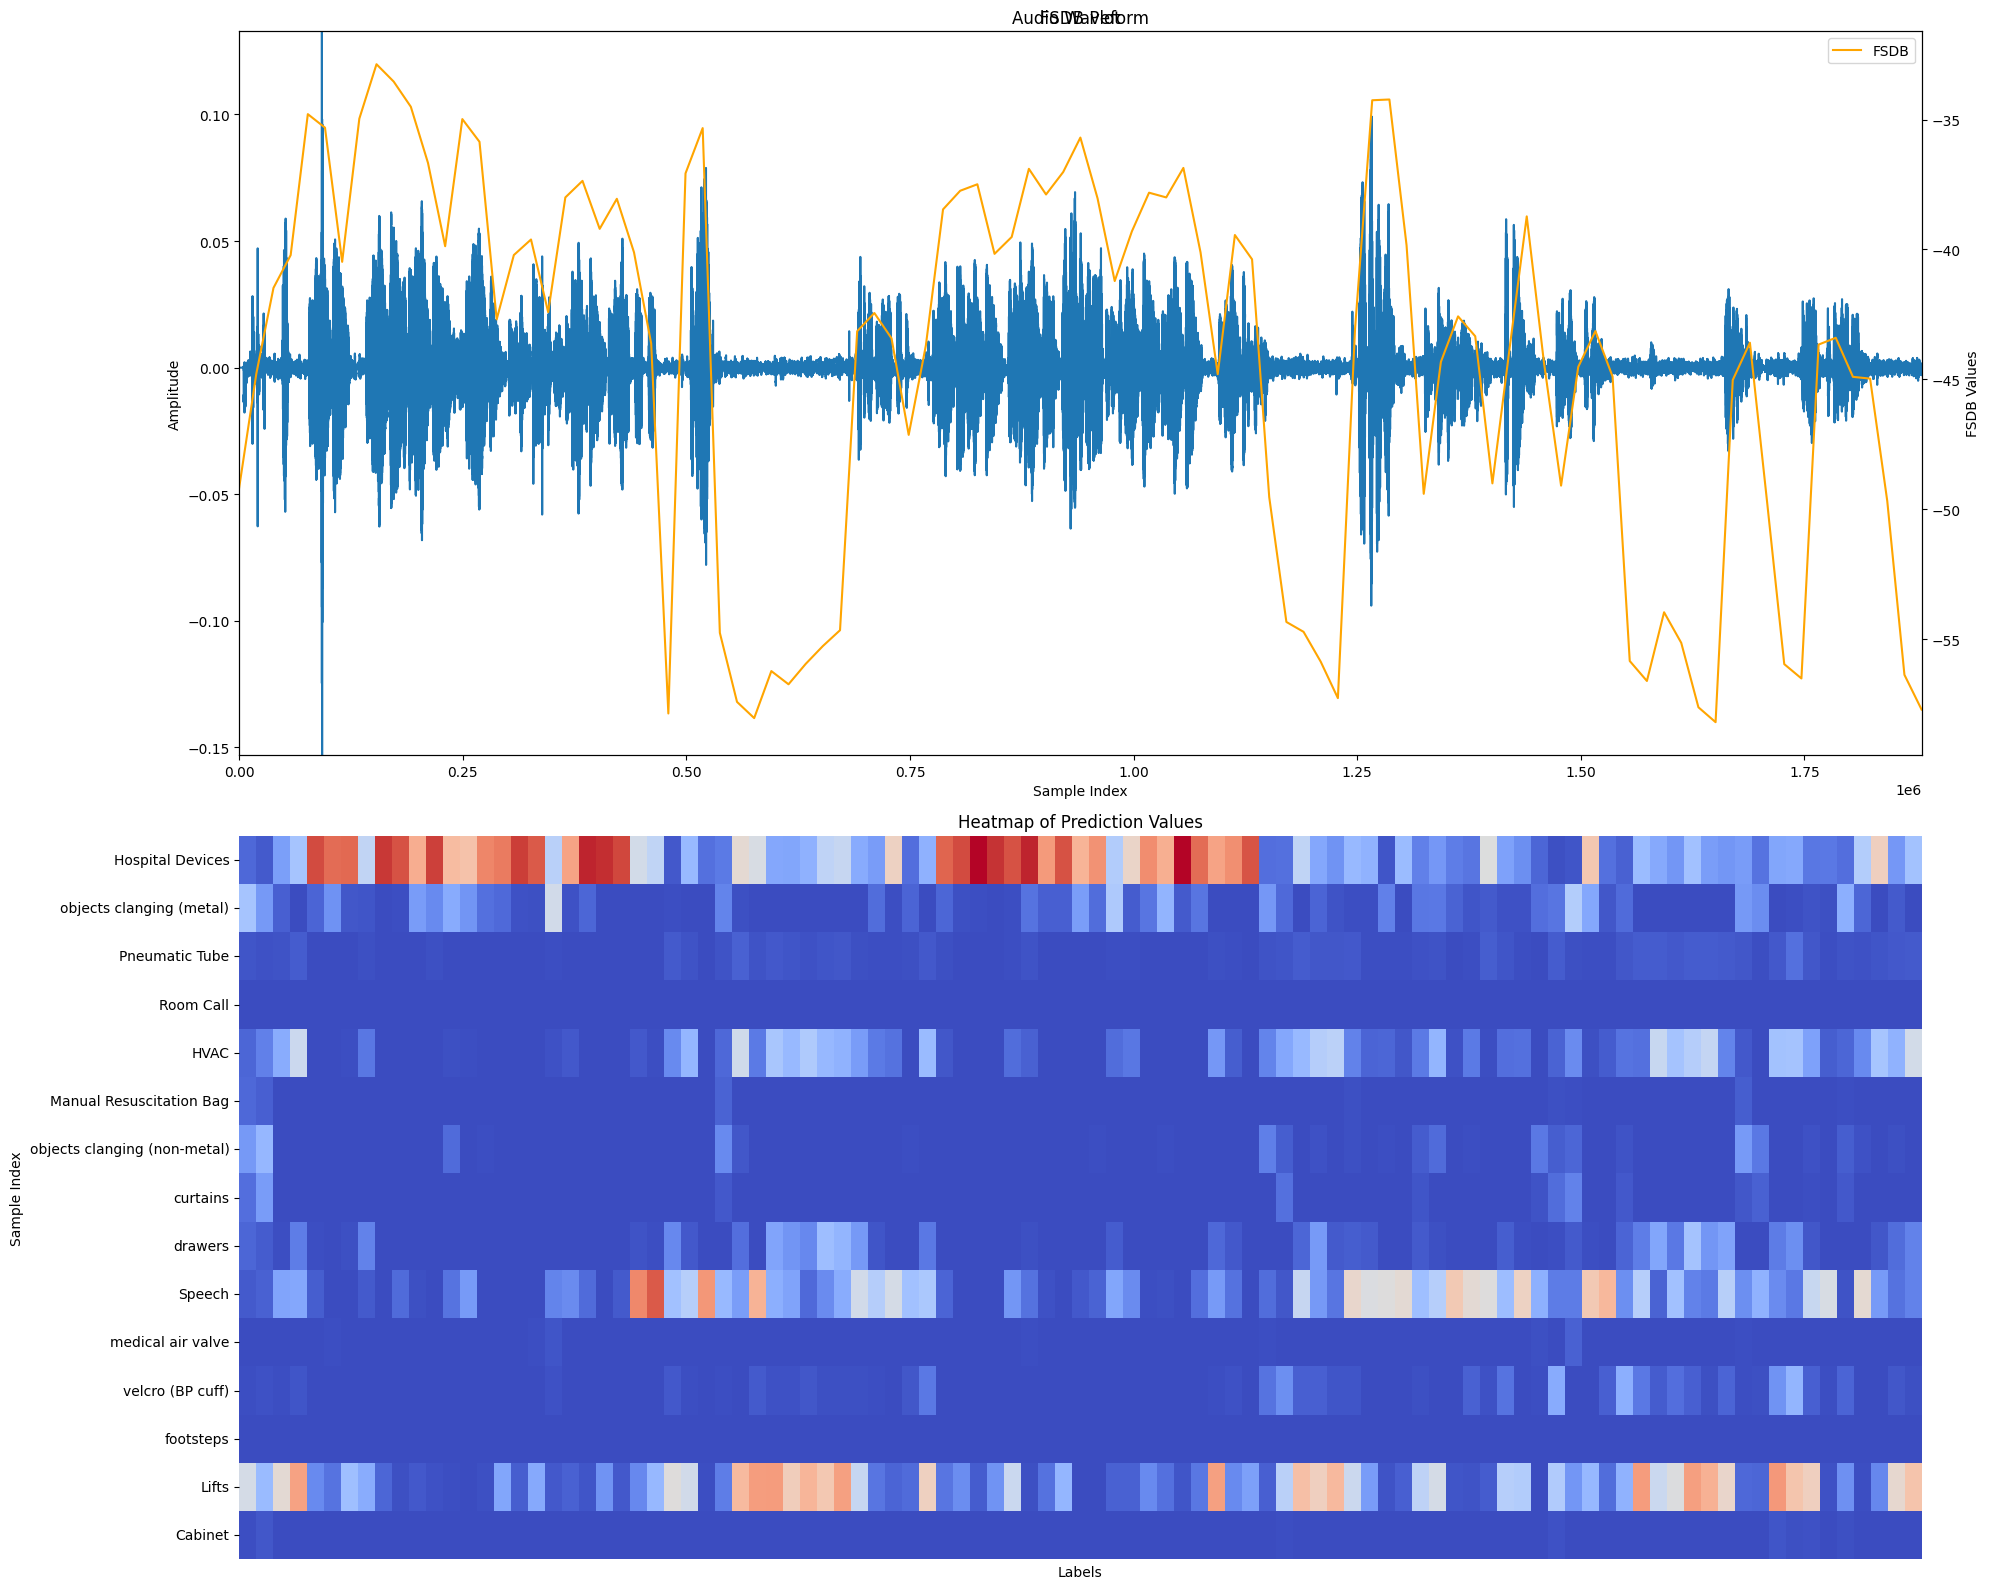

input overflow


In [67]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
# Assuming 'arr' contains the prediction values for each label
# Create a heatmap of the prediction values
# ... existing code ...
# Create a new figure for the demo
# Sample data for demonstration
# Create a new figure for the demo
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(20, 16))  # Create two subplots

# Plot the audio waveform
ax.set_title("Audio Waveform")
ax.plot(audio_files)  # Plot the audio data
ax.set_xlabel("Sample Index")
ax.set_ylabel("Amplitude")
ax.set_xlim(0, len(audio_files))  # Set x-axis limits to match the length of audio_files
ax.margins(0)  # Remove margins

# Create a heatmap of the prediction values
sns.heatmap(arr, annot=False, fmt=".2f", cmap='coolwarm', yticklabels=analyzer.labels, xticklabels=[], cbar=False, ax=ax2)  # Heatmap on ax2
ax2.set_title("Heatmap of Prediction Values")
ax2.set_xlabel("Labels")
ax2.set_ylabel("Sample Index")

ax3 = ax.twinx()
fsdb = [sample['fsdb'] for sample in data]  # Extract fsdb values from data
ax3.plot(np.linspace(0, len(audio_files), len(fsdb)), fsdb, label='FSDB', color='orange')  # Plot fsdb on ax3
ax3.set_ylabel("FSDB Values")
ax3.set_title("FSDB Plot")
ax3.legend()




# Align x-axes
plt.setp(plt.gca().get_xticklabels(), rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()
# ... existing code ...


  0%|          | 0/1764 [00:00<?, ?it/s]

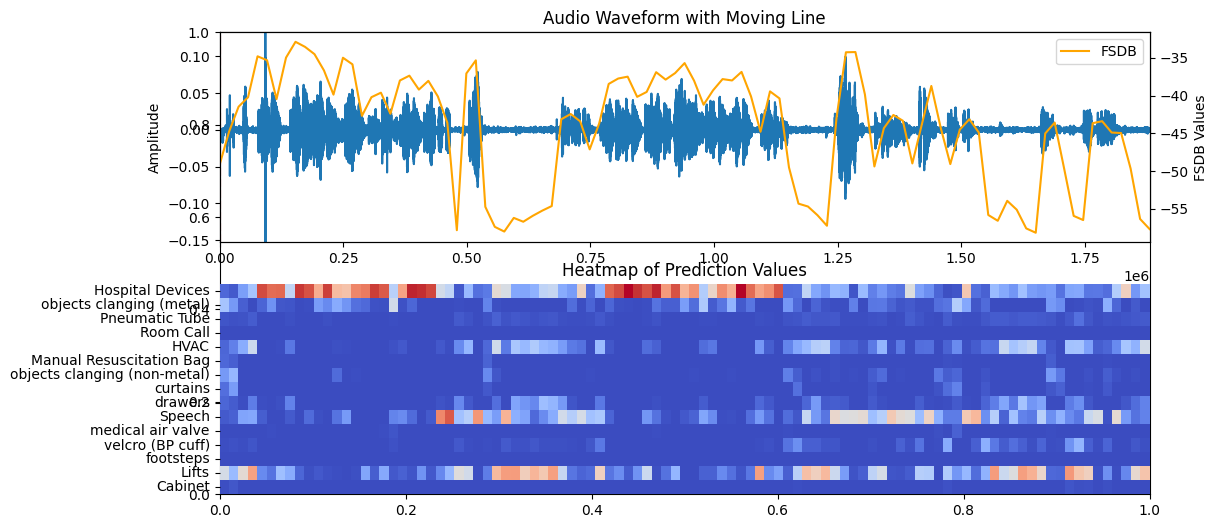

 34%|███▍      | 608/1764 [03:31<07:42,  2.50it/s]

input overflow


 72%|███████▏  | 1276/1764 [07:27<03:33,  2.28it/s]

input overflow


 99%|█████████▉| 1755/1764 [10:12<00:03,  2.87it/s]


IndexError: index 99 is out of bounds for axis 0 with size 99

input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow
input overflow


Exception ignored from cffi callback <function _StreamBase.__init__.<locals>.callback_ptr at 0x0000027233B783A0>:
Traceback (most recent call last):
  File "c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\.venv\lib\site-packages\sounddevice.py", line 857, in callback_ptr
    return _wrap_callback(callback, data, frames, time, status)
  File "c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\.venv\lib\site-packages\sounddevice.py", line 2735, in _wrap_callback
    callback(*args)
  File "C:\Users\Hoon\AppData\Local\Temp\ipykernel_35500\1443195867.py", line 40, in callback
MemoryError: 


In [92]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Rectangle
from tqdm import tqdm
target_sr = 32000
sub_audio = librosa.resample(audio_files, orig_sr=sr, target_sr=target_sr)
chunk_size = 2 * target_sr  # Define chunk size as 3 seconds
hop_size=int(len(sub_audio)/100)

# Create a new figure for the demo
fig, ax = plt.subplots(figsize=(12, 6))  # Adjusted figure size for more space

# Plot the audio waveform
ax = fig.add_subplot(211)
ax.plot(sub_audio, label='Audio Waveform')  # Plot the audio data
ax.set_title("Audio Waveform with Moving Line")
ax.set_ylabel("Amplitude")
ax.set_xlim(0, len(sub_audio))  # Set x-axis limits to match the length of audio_files
ax.set_ylim(np.min(sub_audio), np.max(sub_audio))  # Set y-axis limits based on audio data
ax2 = fig.add_subplot(212)
sns.heatmap(arr, annot=False, fmt=".2f", cmap='coolwarm', yticklabels=analyzer.labels, xticklabels=[], cbar=False)  # xticklabels=np.linspace(0, len(audio_files), 95)[]
ax2.set_title("Heatmap of Prediction Values")

ax3 = ax.twinx()
fsdb = [sample['fsdb'] for sample in data]  # Extract fsdb values from data
ax3.plot(np.linspace(0, len(audio_files), len(fsdb)), fsdb, label='FSDB', color='orange')  # Plot fsdb on ax3
ax3.set_ylabel("FSDB Values")
ax3.legend()

a = list(range(0, len(sub_audio) - chunk_size + 1, hop_size))
# Create a vertical line that will move across the waveform
# ... existing code ...

# Create a vertical line that will move across the waveform
line = ax.axvline( color='r', linestyle='--')  # Initial position of the line
# Animation update function
# a = list(np.linspace(0,500,len(data)-2, dtype=int))

rendering_frame = np.linspace(0, len(sub_audio), round(len(sub_audio)/target_sr * 30), dtype=int)

def update(frame):
    if frame not in rendering_frame:
        return line,
    if frame < len(sub_audio) and frame !=0:
        for f in ax2.get_yticklabels():
            f.set_color('black')
        idx = round(frame/len(sub_audio)*len(data))
        ax2.get_yticklabels()[np.argmax(arr.T[idx])].set_color('red')
        line.set_xdata([frame,])  # Update the x position of the line
    return line, 
# Create the animation
# ... existing code ...

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=rendering_frame, blit=True, interval=33)
x =np.arange(0, len(rendering_frame))

with tqdm(total=len(x)) as pbar:
    for i in range(len(x)):
        ani._draw_frame(i)
        plt.pause(0.001)  # Allow time for tqdm to update
        pbar.update(1)
# Save the animation

with tqdm(total=len(x)) as pbar:
    ani.save('audio_waveform_animation.mp4', writer='ffmpeg', fps=30, progress_callback=lambda i, n: pbar.update(1))  # Save as MP4 file

plt.tight_layout()
plt.show()

13